In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad, jit, jacfwd

In [2]:
m, b = (2, 10)
x = np.linspace(0, 5, 100)
noise = np.random.normal(size=len(x))
y = x * m + b + noise
outliers = np.random.choice(range(1, len(x)), size=len(x) // 5, replace=False)

In [3]:
y[outliers] += 4 * np.random.normal(loc=2, size=len(y[outliers])) 

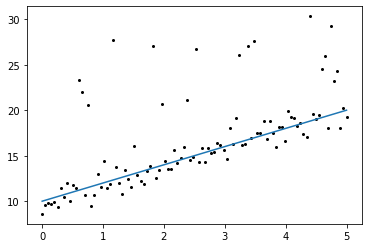

In [4]:
plt.plot(x, y, 'ko', markersize=2)
plt.plot(x, x * m + b)

In [5]:
x_mat = np.vander(x, N=2)

In [6]:
beta_lsq = np.linalg.solve((x_mat.T @ x_mat), x_mat.T @ y)

In [7]:
beta_lsq

array([ 2.14223356, 11.16404411])

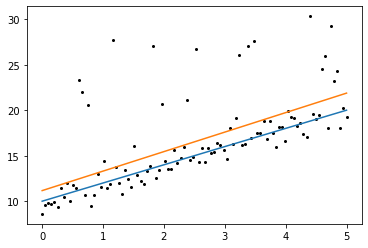

In [8]:
plt.plot(x, y, 'ko', markersize=2)
plt.plot(x, x * m + b)
plt.plot(x, x * beta_lsq[0] + beta_lsq[1])

In [9]:
class kelly_regression:
    def __init__(self, x_mat, y, nu = 4):
        self.x_mat = x_mat
        self.y = y
        self.nu = nu
        self.fun = []
    
    def objective_fun(self, weights):
        return jnp.sum(jnp.log(1 + (1/self.nu) * (y - self.x_mat @ weights) ** 2))
    
    def gradient(self):
        return jit(jacfwd(self.objective_fun))
    
    def optimize(self, learning_rate=1e-4, maxiter=10000):
        grad = self.gradient()
        # start with least squares solution
        weights_start = np.linalg.solve((x_mat.T @ x_mat), x_mat.T @ y)
        weights_kr = weights_start.copy()
        weights_next = weights_start.copy()
        fun_start = self.objective_fun(weights_start)
        self.fun.append(fun_start)
        for i in range(maxiter):
            weights_kr += - learning_rate * grad(weights_kr)
            fun_next = self.objective_fun(weights_kr)
            self.fun.append(fun_next)
            has_weights_converged = (
                np.abs(weights_kr - weights_next)
                <= 0.5 * 1e-6 * (np.abs(weights_kr) + np.abs(weights_next))
            ).all()
            if has_weights_converged:
                break
            else:
                weights_next = weights_kr
        return weights_kr

In [10]:
kr = kelly_regression(x_mat, y, nu = 4)

In [11]:
beta_kr = kr.optimize()

In [12]:
beta_kr

DeviceArray([2.1451786, 9.672718 ], dtype=float32)

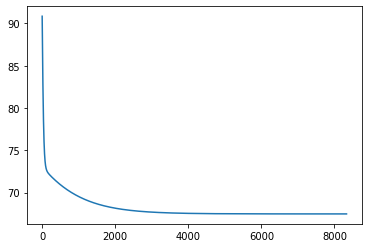

In [13]:
plt.plot(kr.fun)

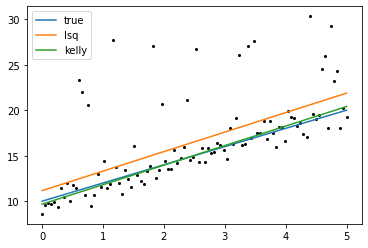

In [14]:
plt.plot(x, y, 'ko', markersize=2)
plt.plot(x, x * m + b, label="true")
plt.plot(x, x * beta_lsq[0] + beta_lsq[1], label="lsq")
plt.plot(x, x * beta_kr[0] + beta_kr[1], label='kelly')
plt.legend()